In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import xgboost as xgb
from utils import *

In [2]:
X, y, beta, Sigma = simulate_data(n=2000, d=10, rho=0.9, seed=1080)
data = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
data.rename(columns={data.shape[1]-1: 'y'}, inplace=True)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1,
                                                  random_state=1234)
skrf = RandomForestClassifier(max_depth=3, random_state=0)
skrf.fit(X_train, y_train)
skpreds = skrf.predict(X_val)

# access trees
# trees = skrf.estimators_
A, metadata = make_adjacency(skrf, X_train)
A_new = new_adjacency(skrf, X_val, metadata)
D = 1-A

In [4]:
eigenvalues, eigenvectors = np.linalg.eigh(A)

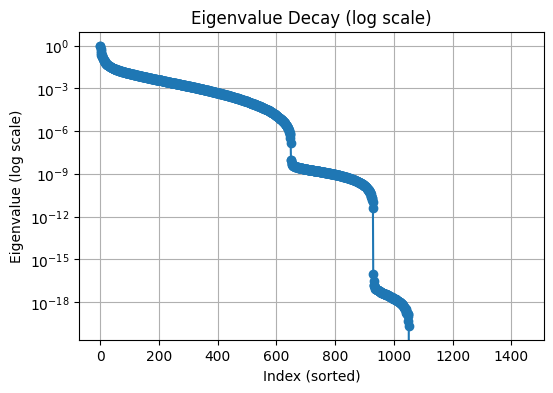

In [5]:
eigenvalues = np.sort(eigenvalues)[::-1]
plt.figure(figsize=(6,4))
plt.semilogy(eigenvalues, marker='o')
plt.xlabel("Index (sorted)")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Eigenvalue Decay (log scale)")
plt.grid(True)
plt.show()

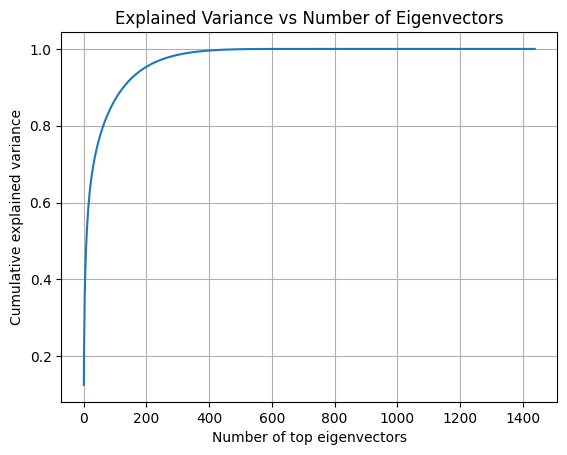

In [6]:
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
plt.plot(explained_variance)
plt.xlabel("Number of top eigenvectors")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance vs Number of Eigenvectors")
plt.grid(True)
plt.show()

In [7]:
class eigenNN(nn.Module):
    def __init__(self, input_dim, output_dim, use_cuda, hidden_dim=200):
        super(eigenNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [19]:
batch_size = 100
M = 10
input_dim = 10
output_dim = M
lr = 5e-4
batch_size = 128
epochs = 1000
log_interval = 5
use_cuda = False
weight_decay = 5e-4
device = torch.device("cuda" if use_cuda else "cpu")
# Inspection
lambda_M = eigenvalues[:M]
psi_M = eigenvectors[:, :M]

In [20]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        """
        X: DataFrame (features)
        y: numpy array (labels)
        """
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
train_dataset = TabularDataset(X_train, psi_M)
lambda_inv = np.diag(1.0/lambda_M)
psi_val = A_new @ psi_M @ lambda_inv
val_dataset = TabularDataset(X_val, psi_val)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=True
)

In [22]:
tree = eigenNN(input_dim, output_dim, use_cuda)
optimizer = torch.optim.Adam(tree.parameters(),
                             lr=lr)
val_acc_list = []
training_loss_list = []
#criterion = nn.KLDivLoss(reduction='batchmean')
criterion = nn.MSELoss()
for epoch in range(epochs):
    tree.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size()[0]
        data, target = data.to(device), target.to(device)
        output = tree.forward(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            msg = (
                "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f}"
            )
            print(msg.format(epoch, batch_idx, loss.item()))
            training_loss_list.append(loss.cpu().item())

    tree.eval()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = tree.forward(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(val_loader.dataset)
    print(f"\nEpoch {epoch:02d} | Testing Avg Loss: {avg_loss:.5f}\n")
    val_acc_list.append(avg_loss)            

Epoch: 00 | Batch: 000 | Loss: 0.00968
Epoch: 00 | Batch: 005 | Loss: 0.00290
Epoch: 00 | Batch: 010 | Loss: 0.00171

Epoch 00 | Testing Avg Loss: 0.00076

Epoch: 01 | Batch: 000 | Loss: 0.00152
Epoch: 01 | Batch: 005 | Loss: 0.00135
Epoch: 01 | Batch: 010 | Loss: 0.00116

Epoch 01 | Testing Avg Loss: 0.00048

Epoch: 02 | Batch: 000 | Loss: 0.00114
Epoch: 02 | Batch: 005 | Loss: 0.00103
Epoch: 02 | Batch: 010 | Loss: 0.00101

Epoch 02 | Testing Avg Loss: 0.00029

Epoch: 03 | Batch: 000 | Loss: 0.00092
Epoch: 03 | Batch: 005 | Loss: 0.00076
Epoch: 03 | Batch: 010 | Loss: 0.00079

Epoch 03 | Testing Avg Loss: 0.00021

Epoch: 04 | Batch: 000 | Loss: 0.00084
Epoch: 04 | Batch: 005 | Loss: 0.00086
Epoch: 04 | Batch: 010 | Loss: 0.00087

Epoch 04 | Testing Avg Loss: 0.00018

Epoch: 05 | Batch: 000 | Loss: 0.00075
Epoch: 05 | Batch: 005 | Loss: 0.00071
Epoch: 05 | Batch: 010 | Loss: 0.00086

Epoch 05 | Testing Avg Loss: 0.00016

Epoch: 06 | Batch: 000 | Loss: 0.00065
Epoch: 06 | Batch: 005 | 

In [23]:
c = lambda_M * psi_M
with torch.no_grad():
    output = tree(torch.tensor(X_test.values, dtype=torch.float32)).T

In [24]:
results = (c @ output.numpy()).T @ y_train
results[results > 0] = 1
results[results < 0] = 0
accuracy_score(results, y_test)

0.4875

In [25]:
results

array([0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0.